<a href="https://colab.research.google.com/github/shivam-909/ichack2024/blob/main/hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy scipy tensorflow

In [39]:
import pandas as pd

etf_prices = pd.read_csv("openbb_ETF_KRBN_20240203_162956.csv")

acr_issuance = pd.read_csv("ACR-Issuance.csv")[["Project Name", "Date Issued", "Total Credits Issued"]]
acr_issuance.columns = ["Project Name", "Date", "Credits Issued"]

arb_issuance = pd.read_csv("ARB-Issuance.csv")[["Project Name", "Issuance Date", "ARB Offset Credits Issued"]]
arb_issuance.columns = ["Project Name", "Date", "Credits Issued"]

car_issuance = pd.read_csv("CAR-Issuance.csv")[["Project \nName", "Date \nIssued", "Total Offset Credits Issued"]]
print(car_issuance.columns)
car_issuance.columns = ["Project Name", "Date", "Credits Issued"]

gold_issuance = pd.read_csv("Gold-Issuance.csv")[["Project Name", "Issuance Date", "Quantity"]]
gold_issuance.columns = ["Project Name", "Date", "Credits Issued"]

vcs_issuance = pd.read_csv("VCS-Issuance.csv")[["Project Name", "Issuance Date", "Credits Issued"]]
vcs_issuance.columns = ["Project Name", "Date", "Credits Issued"]

issuance_dfs = [acr_issuance, arb_issuance, car_issuance, gold_issuance, vcs_issuance]
for df in issuance_dfs:
    df['Credits Issued'] = pd.to_numeric(df['Credits Issued'], errors='coerce')
    df['Credits Issued'] = df['Credits Issued'].fillna(0)
    df['Date'] = pd.to_datetime(df['Date'])

issuance_data = pd.concat(issuance_dfs)

etf_prices['Date'] = pd.to_datetime(etf_prices['Date'])
final_df = pd.merge(etf_prices, issuance_data, on='Date', how='left')

final_df['Credits Issued'] = final_df['Credits Issued'].fillna(0)
df = final_df[final_df['Credits Issued'] != 0]

df

Index(['Project \nName', 'Date \nIssued', 'Total Offset Credits Issued'], dtype='object')


,Date,Open,High,Low,Close,Volume,Project Name,Credits Issued
20,2020-08-03,20.250000,20.455000,20.250000,15.484138,5100,Verwey Hanford Dairy Digester,41346.0
21,2020-08-03,20.250000,20.455000,20.250000,15.484138,5100,Verwey Madera Dairy Digester,33561.0
31,2020-08-05,20.700001,20.900000,20.700001,15.768008,11000,Kimble Sanitary Landfill Gas Project,146875.0
37,2020-08-06,21.010000,21.020000,20.500000,15.561350,2900,GS1247 VPA 45 Eritrean District Boreholes,849.0
39,2020-08-06,21.010000,21.020000,20.500000,15.561350,2900,GS1247 VPA 46 Eritrean District Boreholes,849.0
...,...,...,...,...,...,...,...,...
11545,2023-10-18,36.330002,36.459999,36.310001,35.097164,83400,GS1247 VPA 193 Zambia Eastern Province Safe Wa...,597.0
11547,2023-10-18,36.330002,36.459999,36.310001,35.097164,83400,GS1247 VPA 194 Zambia Eastern Province Safe Wa...,447.0
11620,2023-10-25,36.160000,36.299999,36.090000,34.981167,42300,IESI-Trinity Timber Ridge Landfill Carbon Project,11297.0
11621,2023-10-25,36.160000,36.299999,36.090000,34.981167,42300,IESI-Trinity Timber Ridge Landfill Carbon Project,81230.0


In [36]:
df.set_index('Date', inplace=True)

In [38]:
from scipy.interpolate import UnivariateSpline
import numpy as np

def interpolate_with_spline(series, degree=3):
    idx_non_missing = np.arange(len(series))[~series.isnull()]
    values_non_missing = series[~series.isnull()]
    spline = UnivariateSpline(idx_non_missing, values_non_missing, k=degree, s=0)
    series_interp = series.copy()
    series_interp[series.isnull()] = spline(np.arange(len(series))[series.isnull()])
    return series_interp

for column in ['Open', 'High', 'Low', 'Close']:
    df[column] = interpolate_with_spline(df[column])

KeyError: 'Open'

In [14]:
df

,Open,High,Low,Close
Date,,,,
2020-07-31,20.580000,20.580000,20.368999,15.419037
2020-08-03,20.250000,20.455000,20.250000,15.484138
2020-08-04,20.400000,20.820000,20.299999,15.665058
2020-08-05,20.700001,20.900000,20.700001,15.768008
2020-08-06,21.010000,21.020000,20.500000,15.561350
...,...,...,...,...
2024-01-29,31.490000,31.490000,30.915001,31.000000
2024-01-30,31.170000,31.764999,31.170000,31.650000
2024-01-31,31.600000,31.950001,31.600000,31.700001


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

ts = df['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
ts = scaler.fit_transform(ts)

KeyError: 'Close'

In [20]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

train_size = int(len(ts) * 0.67)
test_size = len(ts) - train_size
train, test = ts[0:train_size,:], ts[train_size:len(ts),:]

look_back = 3
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

Epoch 1/100
587/587 - 3s - loss: 0.1261 - 3s/epoch - 5ms/step
Epoch 2/100
587/587 - 1s - loss: 0.0155 - 1s/epoch - 2ms/step
Epoch 3/100
587/587 - 1s - loss: 0.0025 - 1s/epoch - 2ms/step
Epoch 4/100
587/587 - 1s - loss: 0.0013 - 1s/epoch - 3ms/step
Epoch 5/100
587/587 - 1s - loss: 0.0012 - 1s/epoch - 2ms/step
Epoch 6/100
587/587 - 1s - loss: 0.0012 - 982ms/epoch - 2ms/step
Epoch 7/100
587/587 - 1s - loss: 0.0012 - 965ms/epoch - 2ms/step
Epoch 8/100
587/587 - 1s - loss: 0.0012 - 978ms/epoch - 2ms/step
Epoch 9/100
587/587 - 1s - loss: 0.0011 - 964ms/epoch - 2ms/step
Epoch 10/100
587/587 - 1s - loss: 0.0012 - 991ms/epoch - 2ms/step
Epoch 11/100
587/587 - 1s - loss: 0.0011 - 960ms/epoch - 2ms/step
Epoch 12/100
587/587 - 1s - loss: 0.0011 - 983ms/epoch - 2ms/step
Epoch 13/100
587/587 - 1s - loss: 0.0011 - 978ms/epoch - 2ms/step
Epoch 14/100
587/587 - 1s - loss: 0.0011 - 972ms/epoch - 2ms/step
Epoch 15/100
587/587 - 1s - loss: 0.0011 - 1s/epoch - 2ms/step
Epoch 16/100
587/587 - 1s - loss: 0.0

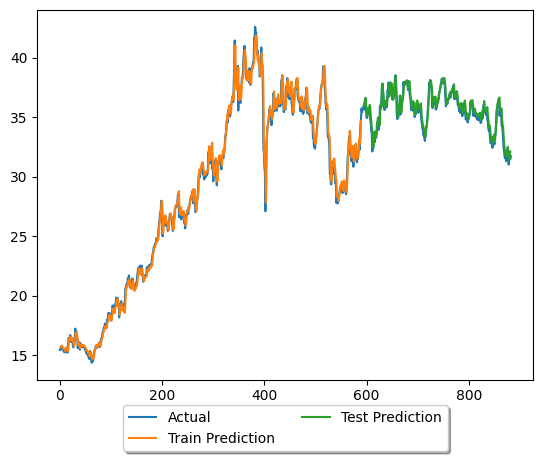

In [25]:
import matplotlib.pyplot as plt

trainPredictPlot = np.empty_like(ts)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(ts)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(ts)-1, :] = test_predict

plt.plot(scaler.inverse_transform(ts), label='Actual')
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)

plt.show()

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


std_dev = np.std(ts)
print(f'Standard Deviation of the Time Series Data: {std_dev}')

train_mae = mean_absolute_error(Y_train[0], train_predict[:,0])
train_mse = mean_squared_error(Y_train[0], train_predict[:,0])
train_rmse = np.sqrt(train_mse)

test_mae = mean_absolute_error(Y_test[0], test_predict[:,0])
test_mse = mean_squared_error(Y_test[0], test_predict[:,0])
test_rmse = np.sqrt(test_mse)

# Print out the metrics
print('Training Data Metrics:')
print(f'MAE: {train_mae}')
print(f'MSE: {train_mse}')
print(f'RMSE: {train_rmse}')

print('\nTest Data Metrics:')
print(f'MAE: {test_mae}')
print(f'MSE: {test_mse}')
print(f'RMSE: {test_rmse}')

Standard Deviation of the Time Series Data: 0.2596845523963353
Training Data Metrics:
MAE: 0.48767934178574934
MSE: 0.5195407634230057
RMSE: 0.72079176148386

Test Data Metrics:
MAE: 0.4392515553368461
MSE: 0.3037354495726906
RMSE: 0.5511219915524063
